In [11]:
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rc
sns.set(font_scale=1.5)
sns.set_style("white")

In [12]:
sketch_names = []
sketch_name_to_idx = dict()
mem_size_in_bytes = []
tot_utime_in_ms = [] # the total update time since beginning
avg_qtime_in_ms = [] # the average query time after inserting a batch of logs

ATTP_sketch_log_filename = 'scalability_logs/scalability-test-client-id.log'

# collect unique sketch names
i_begin_attp_sketch = len(sketch_name_to_idx)
f = open(ATTP_sketch_log_filename, 'r')
for line in f:
    if line.find('Time stats') != -1:
        break
    if line.find('MB') != -1:
        p = 0
        while line[p] == ' ' or line[p] == '\t':
            p += 1
        p2 = line.find(':', p)
        sketch_name = line[p:p2]
        if sketch_name not in sketch_name_to_idx:
            i = len(sketch_name_to_idx)
            sketch_name_to_idx[sketch_name] = i
            sketch_names.append(sketch_name)
            mem_size_in_bytes.append([])
            tot_utime_in_ms.append([])
            avg_qtime_in_ms.append([])
i_end_attp_sketch = len(sketch_name_to_idx)
f.close()

# collect stats
f = open(ATTP_sketch_log_filename, 'r')
i = i_begin_attp_sketch
part = -1
for line in f:
    if part == -1:
        if line.find('Memory Usage') != -1:
            part = 0
    elif part == 0:
        p1 = line.find(':') + 2
        p2 = line.find(' ', p1)
        mem_size_in_bytes[i].append(eval(line[p1:p2]))
        i += 1
        if i == i_end_attp_sketch:
            part += 1
            i = i_begin_attp_sketch
    elif part <= 2:
        part += 1
    elif part == 3:
        p1 = line.find('=') + 2
        p2 = line.find(' ', p1)
        tot_utime_in_ms[i].append(eval(line[p1:p2]))
        i += 1
        if i == i_end_attp_sketch:
            part += 1
            i = i_begin_attp_sketch
    elif part == 4:
        part += 1
    else:
        p1 = line.find('=') + 2
        p2 = line.find(' ', p1)
        avg_qtime_in_ms[i].append(eval(line[p1:p2]))
        i += 1
        if i == i_end_attp_sketch:
            part = -1
            i = i_begin_attp_sketch

# remove the last stats from each of the arrays, which are the global total
# and shouldn't be used in the plots
for i in xrange(i_begin_attp_sketch, i_end_attp_sketch):
    del mem_size_in_bytes[i][-1]
    del tot_utime_in_ms[i][-1]
    del avg_qtime_in_ms[i][-1]
    for j in xrange(len(avg_qtime_in_ms[i]) - 1, 0, -1):
        avg_qtime_in_ms[i][j] -= avg_qtime_in_ms[i][j - 1]
        avg_qtime_in_ms[i][j] /= 5.0

sketch_name_to_idx['vertica_wo_preagg'] = len(sketch_names)
sketch_names.append('vertica_wo_preagg')
sketch_name_to_idx['vertica_w_preagg']  = len(sketch_names)
sketch_names.append('vertica_w_preagg')
mem_size_in_bytes.extend([[], []])
tot_utime_in_ms.extend([[], []])
avg_qtime_in_ms.extend([[], []])

for sketch_name in ['vertica_wo_preagg', 'vertica_w_preagg']:
    if sketch_name == 'vertica_wo_preagg':
        filename = 'scalability_logs/scalability-test-vertica-wo-preagg.log'
    else:
        filename = 'scalability_logs/scalability-test-vertica-w-preagg.log'
    i = sketch_name_to_idx[sketch_name]
    f = open(filename, 'r')
    for line in f:
        if line.startswith('--'):
            tot_utime_in_ms[i].append(0)
            avg_qtime_in_ms[i].append(0)
            break
    for line in f:
        if line.startswith('--'):
            tot_utime_in_ms[i].append(0)
            avg_qtime_in_ms[i].append(0)
        elif line.startswith('Select'):
            p1 = line.find('in ') + 3
            p2 = line.find(' ', p1)
            avg_qtime_in_ms[i][-1] += eval(line[p1:p2])
        elif line.startswith('day'):
            p1 = line.find('mem')
            if p1 != -1:
                p1 += 6
                p2 = line.find(' ', p1)
                mem_size_in_bytes[i].append(eval(line[p1:p2]))
        else:
            p1 = line.find('in ') + 3
            p2 = line.find(' ', p1)
            tot_utime_in_ms[i][-1] += eval(line[p1:p2]) 
    for j in xrange(1, len(tot_utime_in_ms[i])):
        tot_utime_in_ms[i][j] += tot_utime_in_ms[i - 1][j]
    for j in xrange(len(tot_utime_in_ms[i])):
        avg_qtime_in_ms[i][j] /= 5.0
print sketch_names

['SAMPLING-ss500000', 'CMG-e0.000080', 'vertica_wo_preagg', 'vertica_w_preagg']


In [13]:
# Prepare x data
daily_counts = map(lambda s: eval(s), open('scalability_logs/daily_counts.txt', 'r').readlines())
vday_accumulated_counts = []
for i in xrange(10):
    vday_accumulated_counts.extend(daily_counts)
for i in xrange(1, len(vday_accumulated_counts)):
    vday_accumulated_counts[i] += vday_accumulated_counts[i - 1]
vday_accumulated_query_counts = range(5, 5 * len(mem_size_in_bytes[0]) + 1, 5)

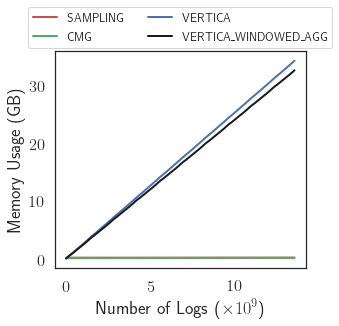

In [14]:
# figure 1: mem vs number of log entries
colors = ["r", "g", "b", "k"]
markers = ["o", "x", "^", "s"]
ms = 0
lw = 2

labels = ["SAMPLING", "CMG", "VERTICA", "VERTICA_WINDOWED_AGG"]

fig, ax = plt.subplots(figsize = (4.5, 4))
xdata = map(lambda x: x / (10. ** 9), vday_accumulated_counts)
for i in xrange(len(labels)):
    mem_size_in_gb = map(lambda x: x / (1024.0 * 1024 * 1024), mem_size_in_bytes[i])
    plt.plot(xdata,
            mem_size_in_gb,
            color = colors[i],
            marker = markers[i],
            label = labels[i].replace('_', '\\_'),
            markersize = ms,
            linewidth = lw)

lgd = ax.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.23), ncol = 2, fontsize = 12)
ax.set_xlabel("Number of Logs ($\\times 10^9$)")
ax.set_ylabel("Memory Usage (GB)")
plt.savefig("scalability_test_memsize.pdf", bbox_extra_artists=[lgd], bbox_inches='tight')

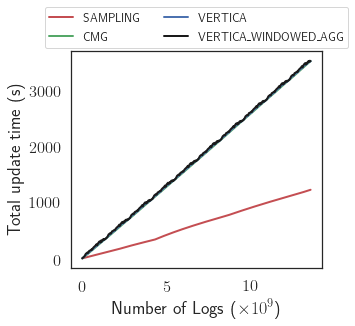

In [15]:
# figure 2: utime vs number of log entries
colors = ["r", "g", "b", "k"]
markers = ["o", "x", "^", "s"]
ms = 0
lw = 2

labels = ["SAMPLING", "CMG", "VERTICA", "VERTICA_WINDOWED_AGG"]

fig, ax = plt.subplots(figsize = (4.5, 4))
xdata = map(lambda x: x / (10. ** 9), vday_accumulated_counts)
for i in xrange(len(labels)):
    ydata = map(lambda x: x / 1000., tot_utime_in_ms[i])
    plt.plot(xdata,
            ydata,
            color = colors[i],
            marker = markers[i],
            label = labels[i].replace('_', '\\_'),
            markersize = ms,
            linewidth = lw)

lgd = ax.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.23), ncol = 2, fontsize = 12)
ax.set_xlabel("Number of Logs ($\\times 10^9$)")
ax.set_ylabel("Total update time (s)")
plt.savefig("scalability_test_utime.pdf", bbox_extra_artists=[lgd], bbox_inches='tight')

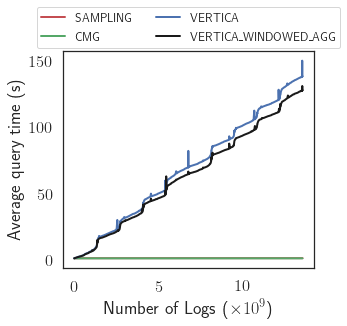

In [16]:
# figure 3: qtime vs number of log entries
colors = ["r", "g", "b", "k"]
markers = ["o", "x", "^", "s"]
ms = 0
lw = 2

labels = ["SAMPLING", "CMG", "VERTICA", "VERTICA_WINDOWED_AGG"]

fig, ax = plt.subplots(figsize = (4.5, 4))
xdata = map(lambda x: x / (10. ** 9), vday_accumulated_counts)
for i in xrange(len(labels)):
    ydata = map(lambda x: x / 1000., avg_qtime_in_ms[i])
    plt.plot(xdata,
            ydata,
            color = colors[i],
            marker = markers[i],
            label = labels[i].replace('_', '\\_'),
            markersize = ms,
            linewidth = lw)

lgd = ax.legend(loc = "upper center", bbox_to_anchor = (0.5, 1.23), ncol = 2, fontsize = 12)
ax.set_xlabel("Number of Logs ($\\times 10^9$)")
ax.set_ylabel("Average query time (s)")
plt.savefig("scalability_test_qtime.pdf", bbox_extra_artists=[lgd], bbox_inches='tight')